In [70]:
import netCDF4
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
from datetime import datetime, timezone, timedelta
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import xmitgcm as xm
import time
import socket

# %matplotlib notebook

In [71]:
from datalakes import download_data_from_datalakes_dataset
from alplakes import parse_alplakes_3d_timeserie_from_directory, get_3d_profile_from_api, open_json, parse_json_3d_profile_to_df, parse_alplakes_1d_from_directory, parse_alplakes_json_3d_timeserie_to_df,parse_alplakes_json_profile_to_df
from utils import save_json
from mitgcm.utils_mitgcm import open_mitgcm_ds_from_config

# Comparison between MITgcm results, simstrat results (from Alplakes) and measurements from Datalakes
This notebook displays :
- the timeserie of the temperature at a given location and depth
- the profile of the temperature at a given location and time
- the heatmap of the profile at a given location

It imports the measure from a netcdf file that can be dowloaded on the datalake platform (https://www.datalakes-eawag.ch/data).
It imports local MITgcm simulation results.

In [72]:
lake_name = "Zurich"
sta_name = 'lower_zurich'

model = 'test_zurich'

In [73]:
var_to_plot = 'THETA'

In [74]:
with open(os.path.join('config_points.json'), 'r') as file:
    config_points = json.load(file)[sta_name]
    
xc_mitgcm_station = config_points['xc_mitgcm_200m']
yc_mitgcm_station = config_points['yc_mitgcm_200m']
xc_mitgcm_station
yc_mitgcm_station

3739

## Import MITgcm results

In [7]:
mitgcm_config, ds_to_plot = open_mitgcm_ds_from_config('mitgcm/config.json', model)

# Import timeseries

In [7]:
#ds_to_plot['time']

In [75]:
start_date = pd.to_datetime(ds_to_plot['time'].values[0],utc=True).to_pydatetime()  #datetime(2024, 1, 1, 0, 0, 0)
end_date = pd.to_datetime(ds_to_plot['time'].values[-1],utc=True).to_pydatetime() #datetime(2025, 1, 1, 0, 0, 0)
end_date

datetime.datetime(2024, 6, 15, 14, 0, tzinfo=datetime.timezone.utc)

 ### Hydronaut or Delft3D

In [77]:
#xr_measure = xr.open_dataset(f'./data/datalakes/geneva_idronaut/2024.nc')
#xr_measure = xr.open_dataset(f'C:/Users/rasmusso/Documents/ZH/data/measurement kanton/zurich_profile_2024.xlsx')

json_folder = f"data/alplakes_3d/{sta_name}/timeseries_0m"

alplakes_timeseries = parse_alplakes_3d_timeserie_from_directory(json_folder)

alplakes_timeseries['time'] = pd.to_datetime(alplakes_timeseries['time'])
alplakes_timeseries = alplakes_timeseries.sort_values(by='time', ascending=True)

print(alplakes_timeseries.head())

                       time  temperature
0 2023-03-01 00:00:00+00:00        6.817
1 2023-03-01 03:00:16+00:00        6.808
2 2023-03-01 06:00:00+00:00        6.792
3 2023-03-01 08:59:44+00:00        6.795
4 2023-03-01 12:00:00+00:00        6.840


### Measurements

In [57]:
measurement_file = rf'data/alplakes_3d/{sta_name}/measurements/{sta_name}_data.csv' 
#use xlsx or csv instead of nc to read the measurements
#df = pd.read_excel(measurement_file,header=1, engine='openpyxl')
df = pd.read_csv(measurement_file)
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
adjusted_meas = df.loc[mask]
adjusted_meas = adjusted_meas.sort_values(by='timestamp', ascending=True)
print(adjusted_meas)

          station                 timestamp              timestamp_cet  \
9491   mythenquai 2024-03-06 01:00:00+00:00  2024-03-06T02:00:00+01:00   
9490   mythenquai 2024-03-06 01:10:00+00:00  2024-03-06T02:10:00+01:00   
9489   mythenquai 2024-03-06 01:20:00+00:00  2024-03-06T02:20:00+01:00   
9488   mythenquai 2024-03-06 01:30:00+00:00  2024-03-06T02:30:00+01:00   
9487   mythenquai 2024-03-06 01:40:00+00:00  2024-03-06T02:40:00+01:00   
...           ...                       ...                        ...   
39440  mythenquai 2024-09-29 23:20:00+00:00  2024-09-30T01:20:00+02:00   
39439  mythenquai 2024-09-29 23:30:00+00:00  2024-09-30T01:30:00+02:00   
39438  mythenquai 2024-09-29 23:40:00+00:00  2024-09-30T01:40:00+02:00   
39437  mythenquai 2024-09-29 23:50:00+00:00  2024-09-30T01:50:00+02:00   
39436  mythenquai 2024-09-30 00:00:00+00:00  2024-09-30T02:00:00+02:00   

       air_temperature  water_temperature  wind_gust_max_10min  \
9491               2.9                6.7    

xr_measure = download_data_from_datalakes_dataset(667, start_date.replace(tzinfo=timezone.utc), end_date.replace(tzinfo=timezone.utc), "idronaut")

## Import simstrat alplakes 1d 

In [9]:
folder_path = '../simstrat_data'
simstrat_data = parse_alplakes_1d_from_directory(folder_path)

ValueError: Invalid isoformat string: '2'

## Plot timeseries temperature at depth "depth_simu"
#### dataklakes

depth_plot=-1 # Value should be negative !!

fig, ax = plt.subplots(1,1,figsize=(15, 7))

if xr_measure is not None:
    meas_selected = xr_measure['temperature']#.sel(depth=depth_plot, method='nearest') #.sel(time=slice(start_date,end_date))
    meas_selected.plot(label=f'Measure Idronaut', color='r')

#simstrat_data['temperature'].sel(depth=-depth_plot, method='nearest').sel(time=slice(start_date,end_date)).plot(label=f'Simstrat 1D', color='g')

sim_selected=ds_to_plot[var_to_plot].sel(Z=depth_plot, XC=xc_mitgcm_station, YC=yc_mitgcm_station, method='nearest') #.sel(time=slice(start_date, end_date))
sim_selected.plot(label='Simulation MITgcm', color='b')

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title(f"Temperature {sta_name} at depth {depth_plot}m")

#plt.savefig(rf"output_plots\{lake_name}\geneva_1year_200m_{depth_plot}m.png")

### alplakes

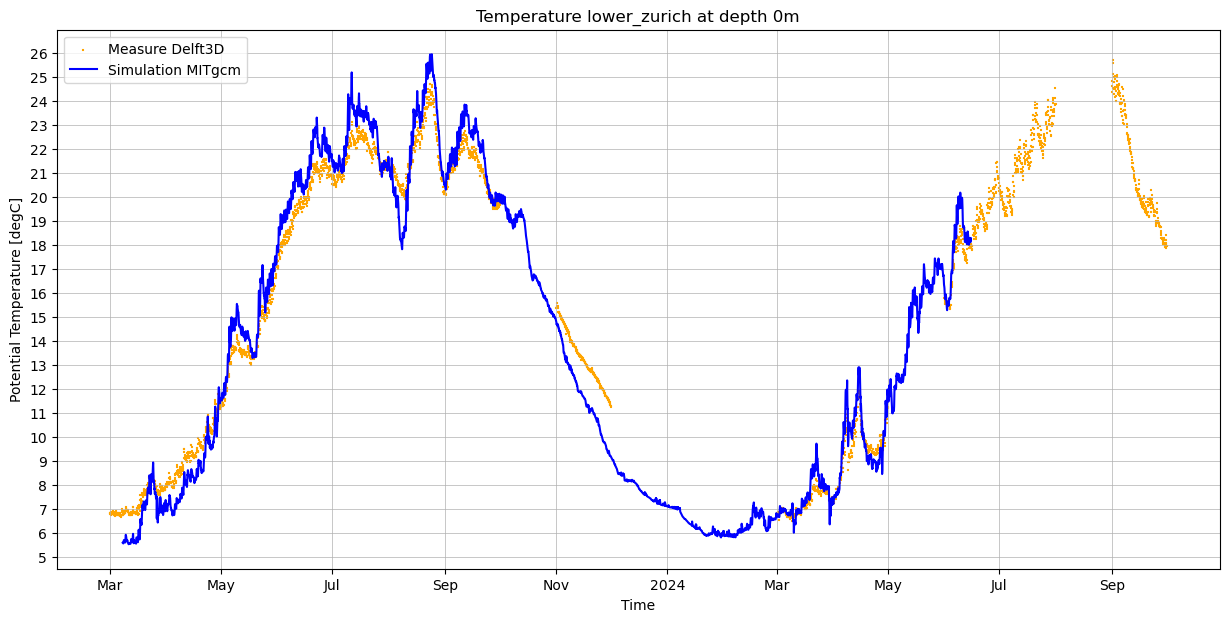

In [78]:
depth_plot=0 # Value should be negative !!

fig, ax = plt.subplots(1,1,figsize=(15, 7))

if alplakes_timeseries is not None:
    #meas_selected = xr_measure['temperature']#.sel(depth=depth_plot, method='nearest') #.sel(time=slice(start_date,end_date))
    plt.scatter(alplakes_timeseries['time'],alplakes_timeseries['temperature'],label=f'Measure Delft3D', marker='+', s=3, c='orange')

#simstrat_data['temperature'].sel(depth=-depth_plot, method='nearest').sel(time=slice(start_date,end_date)).plot(label=f'Simstrat 1D', color='g')
#plt.plot(adjusted_meas.timestamp,adjusted_meas.water_temperature, label=rf'{sta_name} station',color='r', lw=1)

sim_selected=ds_to_plot[var_to_plot].sel(Z=depth_plot, XC=xc_mitgcm_station, YC=yc_mitgcm_station, method='nearest') #.sel(time=slice(start_date, end_date))
sim_selected.plot(label='Simulation MITgcm', color='b')

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title(f"Temperature {sta_name} at depth {depth_plot}m")
#plt.savefig(rf"output_plots/timeseries_{sta_name}_{depth_plot}m.png")
plt.show()

# Import Profile
## alplakes (delf3d)

## simstrat 1D

In [10]:
folder_path = '../simstrat_data'
simstrat_data = parse_alplakes_1d_from_directory(folder_path)

ValueError: Invalid isoformat string: '2'

## measurements canton

In [48]:
measurement_file = rf'data/alplakes_3d/{sta_name}/measurements/{sta_name}_data.xlsx' 
#use xlsx or csv instead of nc to read the measurements
df = pd.read_excel(measurement_file,header=0, engine='openpyxl')
profile_dates_list = df.columns[1:].to_list()
profile_dates = [ v.strftime("%Y.%m.%d") for v in profile_dates_list]


datetime.datetime(2023, 11, 8, 0, 0)

In [68]:
month = 18
date_plot_profil = df.columns[month]
date_plot_profil_str = date_plot_profil.strftime('%Y%m%d%H%M')
print(date_plot_profil)

with open(f"data/alplakes_3d/{sta_name}/profile/{date_plot_profil_str}.json", 'r') as file:
    alplakes_json = json.load(file)
alplakes_profile = parse_alplakes_json_profile_to_df(alplakes_json)

2024-06-05 00:00:00


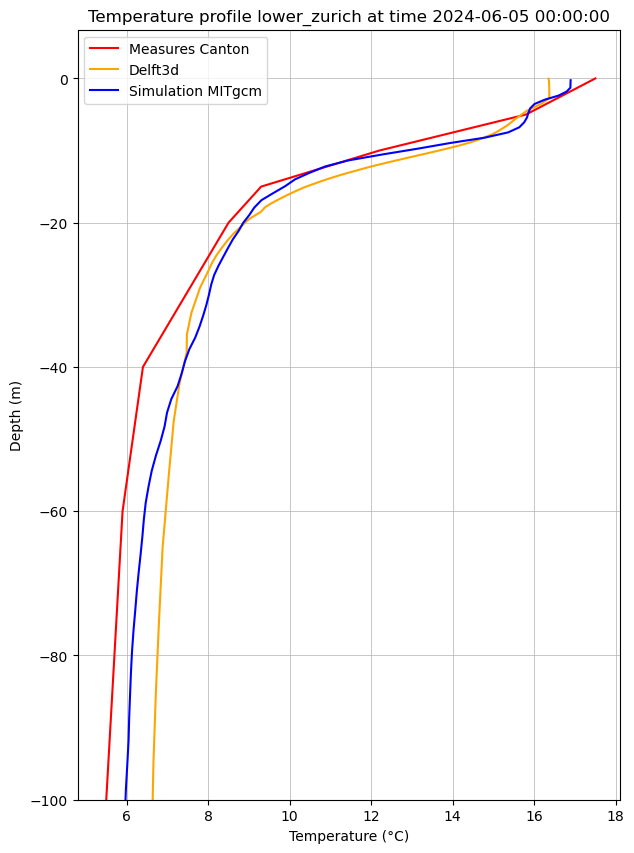

In [69]:
fig = plt.figure(figsize=(7, 10))

#meas_profile = xr_measure['temp'].sel(time=date_plot_profil, method='nearest')
#plt.plot(meas_profile.values, meas_profile.depth.values, label=f'Measure Idronaut', color='r')

# plot the xlsx format, just change the DATE
plt.plot(df[df.columns[month]],-1*df.Depth, label=f'Measures Canton', color='r')

plt.plot(alplakes_profile.temperature,-1*alplakes_profile.depth, label=f'Delft3d', color='orange')
# Convert Simstrat depth to negative and plot
#simstrat_depth_negative = -simstrat_data['depth'].values  # Convert to negative NumPy array
#simstrat_temperature = simstrat_data['temperature'].sel(time=date_plot_profil, method='nearest')
#plt.plot(simstrat_temperature.values, simstrat_depth_negative, label='Simstrat 1D', color='g')


profile_to_plot = ds_to_plot['THETA'].sel(XC=xc_mitgcm_station, YC=yc_mitgcm_station, time=date_plot_profil, method='nearest')
profile_to_plot.where(profile_to_plot != 0, np.nan).plot(y='Z', label='Simulation MITgcm', color='b')

plt.title(f"Temperature profile {sta_name} at time {date_plot_profil}")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.ylabel('Depth (m)')
plt.ylim(bottom=-100)
plt.xlabel('Temperature (°C)')
plt.legend()
plt.savefig(rf"{lake_name}_profile_{date_plot_profil.date()}_UTC.png")
plt.show()